In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import torch

from scipy.interpolate import interp2d
from scipy.stats import beta, multivariate_normal, nct, t

from conformal_utils import *

%load_ext autoreload
%autoreload 2

Note: `get_posterior_quantiles_oracle.py` contains a clean version of this code. The reason I am keeping this notebook around is that it contains code for some visualizations that may be useful. 

**Inputs**:
- A small number of calibration data for each class $k$
- A prior distribution on the Beta distribution parameters. Eventually, we will want to estimate these using maximum likelihood (a la empirical Bayes), but until I figure out how to do that, we will use the KDE distribution fit to the "ground truth" parameters (estimated using all of ImageNet train)

**Output**
- Oracle prior for $\alpha, \beta$

# 1. Setup

## 1a. Prepare inputs

In [2]:
# Load data 
softmax_scores = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_softmax.pt', map_location=torch.device('cpu'))
softmax_scores = softmax_scores.numpy()
labels = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_labels.pt', map_location=torch.device('cpu'))
labels = labels.type(torch.LongTensor).numpy()

In [3]:
n = 20 # Number of calibration points per class k
num_classes = 1000

In [4]:
%%time
softmax_scores_subset, labels_subset, _, _ = split_X_and_y(softmax_scores, labels, n, num_classes=1000, seed=0)

CPU times: user 3.18 s, sys: 1min 22s, total: 1min 26s
Wall time: 1min 26s


In [5]:
# # Select subset of data
# np.random.seed(0)

# softmax_scores_subset = np.zeros((num_classes * n, num_classes))
# labels_subset = np.zeros((num_classes * n, ), dtype=np.int32)

# for k in range(num_classes):
    
#     # Randomly select n instances of class k
#     idx = np.argwhere(labels==k).flatten()
#     selected_idx = np.random.choice(idx, replace=False, size=(n,))
    
#     softmax_scores_subset[n*k:n*(k+1), :] = softmax_scores[selected_idx, :]
#     labels_subset[(n*k):(n*(k+1))] = k

In [6]:
# Only select data for which k is true class
scores_subset = 1 - np.array([softmax_scores_subset[row,labels_subset[row]] for row in range(len(labels_subset))])

In [7]:
# Load KDE estimate of prior
with open('.cache/kde.pkl', 'rb') as f:
    kde = pickle.load(f)

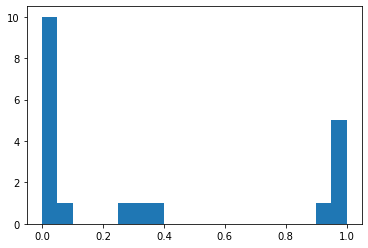

In [8]:
# Sanity check: Plot score distribution for a single class
k = 34
vals = scores_subset[labels_subset==k]
plt.hist(vals, bins=20)
plt.show()

## 1b. Hyperparameters and helper functions

In [9]:
# ===== Hyperparameters =====

# Grid
xmin, xmax = 0, 4 # Grid bounds
ymin, ymax = 0, 4 # Grid bounds
nbins = 100 # Use 100 x 100 grid for now
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j] # Use 100 x 100 grid for now
positions = np.vstack([X.ravel(), Y.ravel()])

# # Threshold for truncating probability distribution
# threshold = .001 # this is over a small area 

# Number of rejection sampling samplies
# num_samples = 1000

# Grid for discretizing Beta mixture
mixture_grid = np.linspace(1e-5,1-(1e-5),2000) # Exclude 0 and 1 since Beta density blows up at those points

# Specify quantile
alpha = 0.1

In [10]:
D = kde(positions) # Evaluate D on grid

In [11]:
def compute_classk_prod_f(k, a, b, n, scores_subset,logscale=False):
    '''
    Computes $\prod_{i=1}^{n_k} f(s_{k,i}; \alpha_k, \beta_k)$
    
    Inputs:
        k: class
        a, b: parameters of Beta(a,b)
        scores_subset: vector in which first n elements are scores for class 0, 
        second n elements are scores for class 1, and so on
    '''
    classk_scores = scores_subset[k*n:(k+1)*n]
    
    # Weirdly, some scores are exactly 0, which is a problem because the Beta 
    # density blows up at 0 for some alpha, beta values. We replace these 0 
    # values with randomly sampled values from classk_scores
    classk_scores[classk_scores == 0] = np.random.choice(classk_scores[~(classk_scores == 0)], 
                                                         size=classk_scores[classk_scores == 0].shape,
                                                         replace=True)
    
    f_ski = beta.pdf(classk_scores, a, b)
    
    if logscale:
        log_prod = np.sum(np.log(f_ski))
        return log_prod
    else:     
        prod = np.prod(f_ski)
        return prod

def compute_prob_on_grid(k, positions, D, xmin, xmax, ymin, ymax, n_k, scores_subset):
    '''
    Applies compute_classk_prod_f to all grid points in positions. Replaces nan entries
    with 0 and normalizes the distribution 
    
    Input:
        -k: class
        -n_k: number of instances of class k
    
    Outputs:
        prob: vector of probabilities
        density: prob reshaped into a matrix
    '''

    prod_f = np.array([compute_classk_prod_f(k, positions[0,i], positions[1,i], n_k, scores_subset) 
                       for i in range(len(positions[0]))])
    prob = prod_f * D

    # Replace nan entries with 0
    prob[np.isnan(prob)] = 0

    # We can normalize this discretized distribution
    grid_area = ((xmax - xmin) / nbins) * ((ymax - ymin) / nbins)
    prob = prob / (np.sum(prob * grid_area))
    
    # Reshape probs from vector into square matrix
    density = np.reshape(prob, X.shape) 
    
    # Check if probability contains NaNs or infs
    if np.sum(np.isnan(prob)) + np.sum(np.isinf(prob)) > 0:
        print(f"WARNING: Probabilities for class {k} contains NaNs and/or inf")

    return prob, density


# def get_quantile(density, grid, alpha):
#     assert(np.sum(np.isnan(density) + np.isinf(density)) == 0)
    
# #     density /= np.sum(density) # ensure that density is normalized to sum to 1
#     grid_width = grid[1] - grid[0]
#     sums = np.cumsum(density) * grid_width
#     min_idx = np.argwhere(sums >= 1 - alpha)[0,0]
    
#     return grid[min_idx]

In [12]:
# %%time

# THIS DOES NOT WORK

# quantiles = np.zeros((num_classes,))

# mixture_grid = np.linspace(1e-3,1-(1e-3),1000) # Exclude 0 and 1 since Beta density blows up at those points

# for k in range(num_classes):
#     print(f"Class {k}")

#     # Computes $\prod_{i=1}^{n_k} f(s_{k,i}; \alpha_k, \beta_k)$
#     prob, prob_matrix = compute_prob_on_grid(k, positions, D, xmin, xmax, ymin, ymax, n, scores_subset)
#     weights = prob / np.sum(prob)
    
#     mixture_density = np.zeros(mixture_grid.shape)
#     for i in range(len(prob)):
# #         print(positions[0,i], positions[1,i])
#         vals = weights[i] * beta.pdf(mixture_grid, positions[0,i], positions[1,i])
#         vals[np.isnan(vals)] = 0 # Replace nan entries with 0
#         mixture_density += vals

#     # Compute quantile
#     print(mixture_density)
#     quantile = get_quantile(mixture_density, mixture_grid, alpha)
#     print(f"Quantile: {quantile:.4f}")
#     quantiles[k] = quantile
    
#     break

# np.save('quantiles_061322_samplingfree.npy', quantiles)

In [13]:
# plt.plot(mixture_density)

In [14]:
# Test seaborn plotting
# x = np.linspace(0,1,20)

# import pandas as pd
# import seaborn as sns
# df = pd.DataFrame({'vals': x})
# sns.relplot(x='vals', y='vals', size="vals", sizes=(20, 200), alpha=0.5, data=df)

## 2. Estimate quantiles

Let $f(x; \alpha, \beta) := \frac{1}{B(\alpha,\beta)}x^{\alpha-1}(1-x)^{\beta-1}$ denote the probability density function of $Beta(\alpha, \beta)$. Let $D(\alpha, \beta)$ denote the prior distribution of the Beta distribution parameters $\alpha$ and $\beta$. 

The distribution of an arbitrary score $s_{k,new}$ for class $k$ is a mixture of Betas:
$$p(s_{k,new}) = \int_0^{\infty} \int_0^{\infty} f(s_{k,new}; \alpha_k, \beta_k) p(\alpha_k, \beta_k | s_k, D) d\alpha_k d\beta_k$$


First, let's figure out how to sample from $p(\alpha_k, \beta_k | s_k, D)$

**Step 1**: Plot $p(\alpha_k, \beta_k | s_k, D)\propto \prod_{i=1}^{n_k} f(s_{k,i}; \alpha_k, \beta_k) D(\alpha, \beta)$

### Sampling approach (6/1/22)
Sample $\alpha_k, \beta_k \sim p(\alpha_k, \beta_k | s_k, D)$. Then sample $s_{k,i} \sim \text{Beta}(\alpha_k, \beta_k)$. Repeat `num_samples` times

In [20]:
%%time

quantiles = np.zeros((num_classes,))

num_samples = 10000 #100000

# Save samples. Row k will contain samples for posterior score distribution for class k
cached_samples = np.zeros((num_classes, num_samples))

for k in range(num_classes):
    print(f"Class {k}")

    # Computes $\prod_{i=1}^{n_k} f(s_{k,i}; \alpha_k, \beta_k)$
    prob, prob_matrix = compute_prob_on_grid(k, positions, D, xmin, xmax, ymin, ymax, n, scores_subset)
    normalized_prob = prob / np.sum(prob)
    
    samples = np.zeros((num_samples,))
    
    for i in range(num_samples):
        
        # 1. Sample alpha_k, beta_k
        idx = np.random.choice(np.arange(len(normalized_prob)), p=normalized_prob)
        alpha_k = positions[0,idx]
        beta_k = positions[1, idx]
#         print('alpha_k, beta_k:', alpha_k, beta_k)
        
        # 2. Sample score
        samples[i] = np.random.beta(alpha_k, beta_k)
        
    # Cache samples for future use
    cached_samples[k,:] = samples

    # Compute quantile
    quantile = np.quantile(samples, 1-alpha, interpolation='higher') 
    
    print(f"Quantile: {quantile:.4f}")
    quantiles[k] = quantile

np.save('quantiles_060822.npy', quantiles) # Save quantiles
np.save('cached_samples_060822.npy', caches_samples) # Save cached samples

Class 0
Quantile: 0.6983
Class 1
Quantile: 0.8671
Class 2
Quantile: 0.9445
Class 3
Quantile: 0.9257
Class 4
Quantile: 0.9245
Class 5
Quantile: 0.9715
Class 6
Quantile: 0.9250
Class 7
Quantile: 0.9564
Class 8
Quantile: 0.9363
Class 9
Quantile: 0.6337
Class 10
Quantile: 0.7680
Class 11
Quantile: 0.8008
Class 12
Quantile: 0.9224
Class 13
Quantile: 0.8525
Class 14
Quantile: 0.7721
Class 15
Quantile: 0.7324
Class 16
Quantile: 0.7510
Class 17
Quantile: 0.6921
Class 18
Quantile: 0.8983
Class 19
Quantile: 0.8449
Class 20
Quantile: 0.8597
Class 21
Quantile: 0.8616
Class 22
Quantile: 0.7650
Class 23
Quantile: 0.8731
Class 24
Quantile: 0.5616
Class 25
Quantile: 0.9639
Class 26
Quantile: 0.9400
Class 27
Quantile: 0.9151
Class 28
Quantile: 0.8103
Class 29
Quantile: 0.7904
Class 30
Quantile: 0.8701
Class 31
Quantile: 0.9601
Class 32
Quantile: 0.9013
Class 33
Quantile: 0.9387
Class 34
Quantile: 0.9837
Class 35
Quantile: 0.9655
Class 36
Quantile: 0.9913
Class 37
Quantile: 0.8491
Class 38
Quantile: 0.9

Quantile: 0.9351
Class 309
Quantile: 0.9177
Class 310
Quantile: 0.9674
Class 311
Quantile: 0.9628
Class 312
Quantile: 0.9306
Class 313
Quantile: 0.7620
Class 314
Quantile: 0.9235
Class 315
Quantile: 0.8923
Class 316
Quantile: 0.6505
Class 317
Quantile: 0.6975
Class 318
Quantile: 0.8547
Class 319
Quantile: 0.9166
Class 320
Quantile: 0.8810
Class 321
Quantile: 0.7186
Class 322
Quantile: 0.7995
Class 323
Quantile: 0.7939
Class 324
Quantile: 0.8282
Class 325
Quantile: 0.8967
Class 326
Quantile: 0.9651
Class 327
Quantile: 0.7626
Class 328
Quantile: 0.7892
Class 329
Quantile: 0.9763
Class 330
Quantile: 0.7151
Class 331
Quantile: 0.8612
Class 332
Quantile: 0.9161
Class 333
Quantile: 0.8575
Class 334
Quantile: 0.5977
Class 335
Quantile: 0.8027
Class 336
Quantile: 0.8185
Class 337
Quantile: 0.9071
Class 338
Quantile: 0.7704
Class 339
Quantile: 0.6720
Class 340
Quantile: 0.6218
Class 341
Quantile: 0.9674
Class 342
Quantile: 0.9084
Class 343
Quantile: 0.7921
Class 344
Quantile: 0.8207
Class 345
Q

Quantile: 0.7999
Class 613
Quantile: 0.9349
Class 614
Quantile: 0.9515
Class 615
Quantile: 0.8667
Class 616
Quantile: 0.9622
Class 617
Quantile: 0.9698
Class 618
Quantile: 0.9989
Class 619
Quantile: 0.9820
Class 620
Quantile: 0.9875
Class 621
Quantile: 0.9638
Class 622
Quantile: 0.9036
Class 623
Quantile: 0.9958
Class 624
Quantile: 0.9924
Class 625
Quantile: 0.8958
Class 626
Quantile: 0.9865
Class 627
Quantile: 0.8789
Class 628
Quantile: 0.8126
Class 629
Quantile: 0.9659
Class 630
Quantile: 0.9314
Class 631
Quantile: 0.9962
Class 632
Quantile: 0.9951
Class 633
Quantile: 0.9883
Class 634
Quantile: 0.9864
Class 635
Quantile: 0.9416
Class 636
Quantile: 0.9815
Class 637
Quantile: 0.9806
Class 638
Quantile: 0.9958
Class 639
Quantile: 0.9934
Class 640
Quantile: 0.5854
Class 641
Quantile: 0.9802
Class 642
Quantile: 0.5875
Class 643
Quantile: 0.9925
Class 644
Quantile: 0.9924
Class 645
Quantile: 0.6988
Class 646
Quantile: 0.9426
Class 647
Quantile: 0.9853
Class 648
Quantile: 0.9900
Class 649
Q

Quantile: 0.9573
Class 917
Quantile: 0.9530
Class 918
Quantile: 0.6144
Class 919
Quantile: 0.9747
Class 920
Quantile: 0.9691
Class 921
Quantile: 0.9637
Class 922
Quantile: 0.9157
Class 923
Quantile: 0.9942
Class 924
Quantile: 0.9578
Class 925
Quantile: 0.9892
Class 926
Quantile: 0.9805
Class 927
Quantile: 0.8467
Class 928
Quantile: 0.9895
Class 929
Quantile: 0.9850
Class 930
Quantile: 0.9800
Class 931
Quantile: 0.8823
Class 932
Quantile: 0.9570
Class 933
Quantile: 0.9390
Class 934
Quantile: 0.9571
Class 935
Quantile: 0.9872
Class 936
Quantile: 0.7861
Class 937
Quantile: 0.9462
Class 938
Quantile: 0.8071
Class 939
Quantile: 0.9528
Class 940
Quantile: 0.9748
Class 941
Quantile: 0.7841
Class 942
Quantile: 0.9300
Class 943
Quantile: 0.9915
Class 944
Quantile: 0.9003
Class 945
Quantile: 0.9572
Class 946
Quantile: 0.6632
Class 947
Quantile: 0.9946
Class 948
Quantile: 0.9695
Class 949
Quantile: 0.9139
Class 950
Quantile: 0.9607
Class 951
Quantile: 0.9657
Class 952
Quantile: 0.8792
Class 953
Q

NameError: name 'caches_samples' is not defined

In [16]:
# k = 137
# plt.hist(scores_subset[labels_subset == k])

## Debugging (pt. 1)

In [17]:
# # Visualize D(alpha, beta)
# max_D = np.max(D)
# for i in range(positions.shape[1]):
#     weight = D[i] / max_D
#     plt.scatter(positions[0,i], positions[1,i], alpha=weight,  color='blue')

# plt.xlabel('$\\alpha$')
# plt.ylabel('$\\beta$')
# plt.title('$D(\\alpha, \\beta)$')
# plt.show()

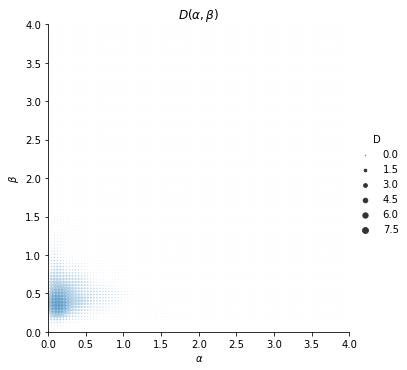

In [18]:
# Visualize D(alpha, beta)
df = pd.DataFrame({'alpha': positions[0,:], 'beta': positions[1,:], 'D': D})
sns.relplot(x='alpha', y='beta', size='D', sizes=(0.1, 40), alpha=0.3, data=df)

plt.ylim(0,4)
plt.xlim(0,4)
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
plt.title('$D(\\alpha, \\beta)$')
plt.show()

In [21]:
# Choose class
k = 3

prob, prob_matrix = compute_prob_on_grid(k, positions, D, xmin, xmax, ymin, ymax, n, scores_subset)

In [ ]:
# Visualize p(\alpha_k, \beta_k | s_k, D)
df = pd.DataFrame({'alpha': positions[0,:], 'beta': positions[1,:], 'prob': prob})
sns.relplot(x='alpha', y='beta', size='prob', sizes=(0.1, 40), alpha=0.3, data=df)

plt.ylim(0,4)
plt.xlim(0,4)
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
plt.title('$p(\\alpha_k, \\beta_k | s_k, D)$')
plt.show()

In [ ]:
# Visualize Beta densities
a = 0.1 # alpha
b = 0.5 # beta

grid = np.linspace(1e-4,1-1e-4,2000)
beta_density = beta.pdf(grid, a, b)
plt.plot(grid, beta_density)
# plt.ylim(bottom=0)
plt.ylim(0,10)
plt.xlim(0,1)
plt.title(f"Density of Beta({a}, {b})")

In [ ]:
alpha = 0.1
get_quantile(beta_density, grid, alpha)

In [ ]:
grid_width = grid[1] - grid[0]
density = beta_density
sums = np.cumsum(density) * grid_width
sums  

In [ ]:
# Inverse cdf
beta.ppf(1-alpha, a, b)

In [ ]:
alpha = 0.1
density = beta_density
grid_width = grid[1] - grid[0]
sums = np.cumsum(density) * grid_width
min_idx = np.argwhere(sums >= 1 - alpha)[0,0]

In [ ]:
alpha = 0.1
density = beta_density
density /= np.sum(density) # ensure that density is normalized to sum to 1
sums = np.cumsum(density)
min_idx = np.argwhere(sums >= 1 - alpha)[0,0]

# return grid[min_idx]
sums
grid[min_idx]

## Debugging (pt. 2)

Compare discretized quantile estimate to ppf quantile estimate for a Beta distribution

In [ ]:
a = 0.1
b = 0.5

# a = 2
# b = 2

alpha = 0.1

## 1.  Discretized
eps = 1e-10 # To avoid evaluating Beta at 0 or 1, where density blows up to infinity for some alpha, beta combos

# Option A: Basic grid
grid = np.linspace(eps, 1-eps, 10000000)

# Option B: Grid with higher density at tails
# grid1 = np.linspace(eps, 0.1, 10000)
# grid2 = np.linspace(0.1, 0.9, 2000)
# grid3 = 1 - grid1
# grid = np.concatenate((grid1, grid2, grid3))
# plt.scatter(grid, np.ones(grid.shape), alpha=0.1) # Visualize grid

disc_beta = beta.pdf(grid, a , b)
grid_width = grid[1] - grid[0]
sums = np.cumsum(disc_beta) * grid_width
# grid_width = grid[1:] - grid[:-1]
# # cumsum = np.cumsum(disc_beta)
# sums = (disc_beta[:1] + disc_beta[1:]) / 2  * grid_width # Midpoint integral
min_idx = np.argwhere(sums >= 1 - alpha)[0,0]
quantile_est1 = grid[min_idx]
print("Discretized quantile estimate:", quantile_est1)

## 2. Using .ppf
quantile_est2 = beta.ppf(1-alpha, a, b)
print("ppf quantile estimate:", quantile_est2)

# Visualize the beta distribution
plt.plot(grid, disc_beta)
# plt.plot(grid, sums)
plt.title(f'Beta({a}, {b}) distribution')
# plt.ylim(bottom = 0)
# plt.xlim(0,1)
plt.show()

In [ ]:
disc_beta

In [ ]:
plt.plot(grid, sums)
plt.plot(grid, beta.cdf(grid, a, b))

In [ ]:
plt.plot(grid[1:], grid_width)
plt.show()